In [ ]:
#%pip install tensorflow==2.4
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports

import matplotlib.pyplot as plt
from math import ceil, sin, cos, sqrt, pi
from itertools import combinations
import h5py
import numpy as np
import sys
import os
import os
from drive.MyDrive.kombiLab.rede.tf_bio import make_grid, rotate
from drive.MyDrive.kombiLab.rede.DataGenerator import DataGenerator
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras import regularizers

In [ ]:
#data
path_val='/content/drive/MyDrive/kombiLab/data/split/validation_set.hdf'
path_train='/content/drive/MyDrive/kombiLab/data/split/training_set.hdf'
path_teste='/content/drive/MyDrive/kombiLab/data/split/test_set.hdf'
path_core2013 = '/content/drive/MyDrive/kombiLab/data/core2013.hdf'
path_ref19 = '/content/drive/MyDrive/kombiLab/pdb2019/refinedset_2019.hdf'
path_ref16 = '/content/drive/MyDrive/kombiLab/pdb2016/refined.hdf'


datasets = ['training', 'validation', 'test', 'core2013', 'refined2019','refined2016' ]
features_names = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal', 'hyb', 'heavyvalence', 'heterovalence', 'partialcharge', 'molcode', 'hydrophobic', 'aromatic', 'acceptor', 'donor', 'ring']
columns = {name: i for i, name in enumerate(features_names)}
ids = {}
affinity = {}
coords = {}
features = {}

for dictionary in [ids, affinity, coords, features]:
    for dataset_name in datasets:
        dictionary[dataset_name] = []

for dataset_name in datasets:
    if (dataset_name == 'training'):
      dataset_path = path_train
    if (dataset_name == 'validation'):
      dataset_path = path_val
    if (dataset_name == 'test'):
      dataset_path = path_teste
    if (dataset_name == 'core2013'):
      dataset_path = path_core2013
    if (dataset_name == 'refined2019'):
      dataset_path = path_ref19
    if (dataset_name == 'refined2016'):
      dataset_path = path_ref16

    with h5py.File(dataset_path, 'r') as f:
        for pdb_id in f:
            dataset = f[pdb_id]

            coords[dataset_name].append(dataset[:, :3])
            features[dataset_name].append(dataset[:, 3:])
            affinity[dataset_name].append(dataset.attrs['affinity'])
            ids[dataset_name].append(pdb_id)

    ids[dataset_name] = np.array(ids[dataset_name])
    affinity[dataset_name] = np.reshape(affinity[dataset_name], (-1, 1))



# normalize charges
charges = []
for feature_data in features['training']:
    charges.append(feature_data[..., columns['partialcharge']])

charges = np.concatenate([c.flatten() for c in charges])

m = charges.mean()
std = charges.std()

print('charges: mean=%s, sd=%s' % (m, std))
print('use sd as scaling factor')



charges: mean=-0.14302106, sd=0.42584962
use sd as scaling factor


In [ ]:

#refined19
refined19_feat = []
refined19_ids = []
refined19_coords = []
refined19_affinity = [] 
for i in range(len(ids['refined2019'])):
  if ((ids['refined2019'][i] in ids['core2013']) or (ids['refined2019'][i] in ids['test'])):
    pass
  else:
    refined19_ids.append(ids['refined2019'][i])
    refined19_feat.append(features['refined2019'][i])
    refined19_coords.append(coords['refined2019'][i]) 
    refined19_affinity.append(affinity['refined2019'][i])

#refined16
refined16_feat = []
refined16_ids = []
refined16_coords = []
refined16_affinity = [] 
for i in range(len(ids['refined2016'])):
  if ((ids['refined2016'][i] in ids['core2013']) or (ids['refined2019'][i] in ids['test'])):
    pass
  else:
    refined16_ids.append(ids['refined2016'][i])
    refined16_feat.append(features['refined2016'][i])
    refined16_coords.append(coords['refined2016'][i]) 
    refined16_affinity.append(affinity['refined2016'][i])

print("refined19  n: ", len(refined19_ids))
print("refined16  n: ", len(refined16_ids))

refined19  n:  4510
refined16  n:  3429


In [ ]:
# Best error we can get without any training (MSE from training set mean):
t_baseline = ((affinity['training'] - affinity['training'].mean()) ** 2.0).mean()
v_baseline = ((affinity['validation'] - affinity['training'].mean()) ** 2.0).mean()
print('baseline mse: training=%s, validation=%s' % (t_baseline, v_baseline))


baseline mse: training=3.528226738267908, validation=3.8604890221015298


In [ ]:


model = tf.keras.models.Sequential(name='paf_keras')

model.add (Conv3D(64, (5, 5, 5), activation='relu', padding='same', strides = (1, 1, 1), input_shape=(21, 21, 21, 19), 
           kernel_regularizer = tf.keras.regularizers.L2(l2=0.001), 
))
model.add (tf.keras.layers.MaxPooling3D(pool_size= (2,2,2), padding='SAME',strides = (2, 2, 2)))

model.add (Conv3D(128, (5, 5, 5), activation='relu', padding='same',
           kernel_regularizer = tf.keras.regularizers.L2(l2=0.001), strides = (1, 1, 1)
))
model.add (tf.keras.layers.MaxPooling3D(pool_size= (2,2,2), padding='same', strides=(2, 2, 2)))

model.add (Conv3D(256, (5, 5, 5), activation='relu', padding='same',
           kernel_regularizer = tf.keras.regularizers.L2(l2=0.001)
))

model.add (tf.keras.layers.MaxPooling3D(pool_size= (2,2,2), padding='SAME', strides=(2, 2, 2)))

model.add (tf.keras.layers.Flatten())
model.add (tf.keras.layers.Dense(1000, activation='relu'))
model.add (tf.keras.layers.Dropout(rate = 0.5))
model.add (tf.keras.layers.Dense(500, activation='relu'))
model.add (tf.keras.layers.Dropout(rate = 0.5))
model.add (tf.keras.layers.Dense(200, activation='relu'))
model.add (tf.keras.layers.Dropout(rate = 0.5))
model.add (tf.keras.layers.Dense(1, activation='linear'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=[ tf.keras.metrics.RootMeanSquaredError(), 'acc' ])


model.summary()


Model: "paf_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 21, 21, 21, 64)    152064    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 11, 11, 11, 64)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 11, 11, 11, 128)   1024128   
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 6, 6, 128)      0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 6, 6, 6, 256)      4096256   
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 3, 3, 3, 256)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6912)              0 

In [ ]:
tf.keras.utils.plot_model(model, to_file='plot.png', show_shapes=True, show_layer_names = False, expand_nested = False)

In [ ]:
from keras.callbacks import ModelCheckpoint
csv_logger = ModelCheckpoint(
    filepath='/content/drive/MyDrive/kombiLab/rede/checkpoint',
    save_weights_only=False,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True
)


In [ ]:
##########################################################
# train generator for refined2016 dataset #
##########################################################
train_generator = DataGenerator(refined16_ids, refined16_feat, refined16_coords, refined16_affinity, batch_size = 5)
val_generator = DataGenerator(ids['validation'].tolist(),features['validation'], coords['validation'], affinity['validation'],batch_size=5, on_training = False)

In [ ]:
##########################################################
# train generator for refined-except-casf2016/13 dataset #
##########################################################
train_generator = DataGenerator(refined19_ids, refined19_feat, refined19_coords, refined19_affinity, batch_size = 5)
val_generator = DataGenerator(ids['validation'].tolist(),features['validation'], coords['validation'], affinity['validation'],batch_size=5, on_training = False)

In [ ]:
########################################
# train generator for original dataset #
########################################

train_generator = DataGenerator(ids['training'].tolist(), features['training'], coords['training'], affinity['training'], batch_size = 5)
val_generator = DataGenerator(ids['validation'].tolist(),features['validation'], coords['validation'], affinity['validation'],batch_size=5, on_training = False)

In [ ]:
history = model.fit(
    train_generator,
    epochs = 8,
    callbacks = csv_logger,
#    validation_split=0.1
    validation_data = val_generator
)



 Rotação:  0 

Epoch 1/8
  683/17125 [>.............................] - ETA: 10:53 - loss: 14.5212 - root_mean_squared_error: 3.6663 - acc: 0.0000e+00
 Rotação:  1 

 1370/17125 [=>............................] - ETA: 10:24 - loss: 11.4856 - root_mean_squared_error: 3.2620 - acc: 0.0000e+00
 Rotação:  2 

 2056/17125 [==>...........................] - ETA: 9:58 - loss: 10.2287 - root_mean_squared_error: 3.0834 - acc: 0.0000e+00
 Rotação:  3 

 2742/17125 [===>..........................] - ETA: 9:32 - loss: 9.5018 - root_mean_squared_error: 2.9758 - acc: 0.0000e+00
 Rotação:  4 

 3428/17125 [=====>........................] - ETA: 9:04 - loss: 9.0204 - root_mean_squared_error: 2.9027 - acc: 0.0000e+00
 Rotação:  5 

 4113/17125 [======>.......................] - ETA: 8:37 - loss: 8.6657 - root_mean_squared_error: 2.8475 - acc: 0.0000e+00
 Rotação:  6 

 4799/17125 [=======>......................] - ETA: 8:10 - loss: 8.3842 - root_mean_squared_error: 2.8025 - acc: 0.0000e+00
 Rotação:  

In [ ]:
model.save('/content/drive/MyDrive/kombiLab/pdb2019/model_8epochs')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kombiLab/pdb2019/model_8epochs/assets


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'acc', 'val_loss', 'val_root_mean_squared_error', 'val_acc'])


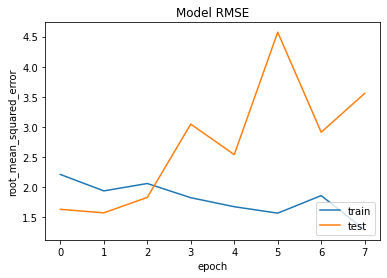

In [ ]:
# summarize history for RMSE
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

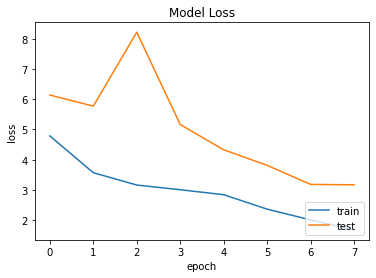

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/rede/model')

history = model.fit(
    train_generator,
    epochs = 15,
    initial_epoch = 8,
    callbacks = csv_logger,
#    validation_split=0.1,
    validation_data = val_generator
)


 Rotação:  0 

Epoch 9/15
  683/17125 [>.............................] - ETA: 10:39 - loss: 1.6873 - root_mean_squared_error: 1.2489 - acc: 0.0000e+00
 Rotação:  1 

 1369/17125 [=>............................] - ETA: 10:15 - loss: 1.4344 - root_mean_squared_error: 1.1432 - acc: 0.0000e+00
 Rotação:  2 

 2056/17125 [==>...........................] - ETA: 9:48 - loss: 1.6397 - root_mean_squared_error: 1.2297 - acc: 0.0000e+00
 Rotação:  3 

 2742/17125 [===>..........................] - ETA: 9:22 - loss: 1.7502 - root_mean_squared_error: 1.2738 - acc: 0.0000e+00
 Rotação:  4 

 3428/17125 [=====>........................] - ETA: 8:55 - loss: 1.8213 - root_mean_squared_error: 1.3014 - acc: 0.0000e+00
 Rotação:  5 

 4113/17125 [======>.......................] - ETA: 8:29 - loss: 1.8587 - root_mean_squared_error: 1.3157 - acc: 0.0000e+00
 Rotação:  6 

 4799/17125 [=======>......................] - ETA: 8:02 - loss: 1.8881 - root_mean_squared_error: 1.3268 - acc: 0.0000e+00
 Rotação:  7 

In [ ]:
model.save('/content/drive/MyDrive/kombiLab/pdb2016/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kombiLab/pdb2016/model/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/pdb2016/model')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/pdb2019/model_15epochs')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/rede/model_ep7')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/rede/model')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/rede/model_ep13')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/rede/model_ep14')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/kombiLab/rede/model_ep15')

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr

def rmse_func(predct, obsv):
  if(len(predct)!=len(obsv)):
    print("error00")
  sum = 0
  for i in range (len(predct)):
    sum = sum + ((predct[i] - obsv[i])**2)
  rmse = sqrt(sum/len(predct))
  psd = np.std(predct)
  return rmse, psd


# Função para calcular o scoring power
def scoring_power(features, features_predicted, positive=True):

    # Calcula o coeficiente de correlação de Pearson:
    linear_reg = linear_model.LinearRegression()

    linear_reg.fit(features_predicted, features)
    testpredy = linear_reg.predict(features_predicted)
    person_r = pearsonr(features.flatten(), features_predicted.flatten())[0]
    testmse = mean_squared_error(features, testpredy)
    num = len(features)
    std_error = np.sqrt((testmse * num) / (num - 1))

    return num, person_r, std_error, "[]"




In [ ]:
#Normalize charges using sd training
for i in range(len(features['test'])):
  features['test'][i][..., columns['partialcharge']] /= std

for i in range(len(features['training'])):
  features['training'][i][..., columns['partialcharge']] /= std

for i in range(len(features['validation'])):
  features['validation'][i][..., columns['partialcharge']] /= std

for i in range(len(features['core2013'])):
  features['core2013'][i][..., columns['partialcharge']] /= std

for i in range(len(refined16_feat)):
  refined16_feat[i][..., columns['partialcharge']] /= std

for i in range(len(refined19_feat)):
  refined19_feat[i][..., columns['partialcharge']] /= std  

In [ ]:
###Predict Test, train and valid
pred_test = []
pred_train = []
pred_valid = []
pred_core2013 = []
pred_refined2019 = []
pred_refined2016 = []

for k in range(len(refined19_coords)):
  pred_refined2019.append(model.predict(make_grid(refined19_coords[k], refined19_feat[k]))) 

for k in range(len(refined16_coords)):
  pred_refined2016.append(model.predict(make_grid(refined16_coords[k], refined16_feat[k]))) 

for k in range(len(coords['test'])):
  pred_test.append(model.predict(make_grid(coords['test'][k], features['test'][k]))) 

for k in range(len(coords['training'])):
  pred_train.append(model.predict(make_grid(coords['training'][k], features['training'][k]))) 

for k in range(len(coords['validation'])):
  pred_valid.append(model.predict(make_grid(coords['validation'][k], features['validation'][k]))) 

for k in range(len(coords['core2013'])):
  pred_core2013.append(model.predict(make_grid(coords['core2013'][k], features['core2013'][k]))) 





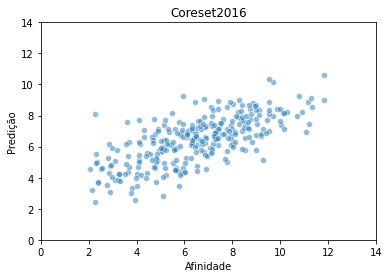

In [ ]:
'''for i in range(len (test_x)):

  print("Affinity ", affinity['test'][i] , "Predict " , test_x[i])
'''
plt.scatter(affinity['test'],pred_test, edgecolors = 'white', alpha = 0.5)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("Coreset2016")
plt.ylabel('Predição')
plt.xlabel('Afinidade')
plt.show()

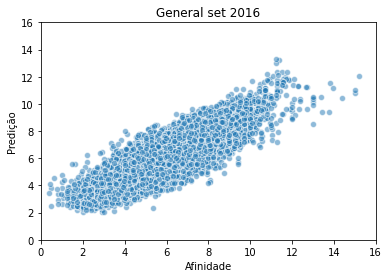

In [ ]:
plt.scatter(affinity['training'],pred_train , edgecolors = 'white',alpha = 0.5)
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.title("General set 2016")
plt.ylabel('Predição')
plt.xlabel('Afinidade')
plt.show()



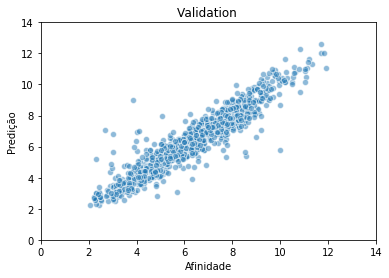

In [ ]:
plt.scatter(affinity['validation'],pred_valid, edgecolors = 'white', alpha = 0.5)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("Validation ")
plt.ylabel('Predição')
plt.xlabel('Afinidade')
plt.show()

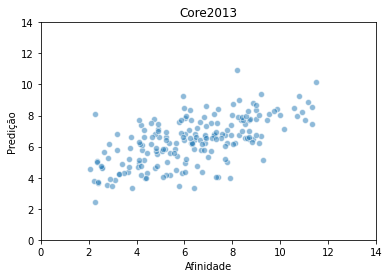

In [ ]:
plt.scatter(affinity['core2013'],pred_core2013, edgecolors = 'white', alpha = 0.5)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("Core2013")
plt.ylabel('Predição')
plt.xlabel('Afinidade')
plt.show()

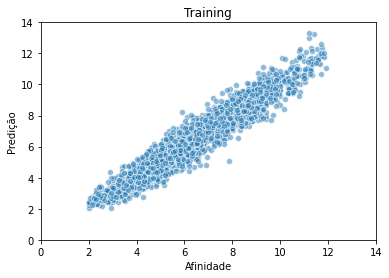

In [ ]:
plt.scatter(refined16_affinity,pred_refined2016, edgecolors = 'white', alpha = 0.5)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("Training")
plt.ylabel('Predição')
plt.xlabel('Afinidade')
plt.show()

In [ ]:
print('Teste RMSE:         ',  rmse_func(pred_test, affinity['test'])[0])
print('Training RMSE:      ',  rmse_func(pred_train, affinity['training'])[0])
print('Validation RMSE:    ',  rmse_func(pred_valid, affinity['validation'])[0])
print('Core2013 RMSE:      ',  rmse_func(pred_core2013, affinity['core2013'])[0])
print('Refined2019 RMSE:   ',  rmse_func(pred_refined2019, refined19_affinity)[0])
print('Refined2016 RMSE:   ',  rmse_func(pred_refined2016, refined16_affinity)[0])

Teste RMSE:          1.554443649220303
Training RMSE:       0.9591298377926674
Validation RMSE:     0.7120093351390976
Core2013 RMSE:       1.7476561716577728
Refined2019 RMSE:    1.0373098123169746
Refined2016 RMSE:    0.5562360164886405


In [ ]:
from scipy.stats.stats import pearsonr

r_teste= pearsonr(affinity['test'].flatten(),np.vstack(pred_test).flatten())[0]
r_core2013 = pearsonr(affinity['core2013'].flatten(),np.vstack(pred_core2013).flatten())[0]
r_training = pearsonr(affinity['training'].flatten(),np.vstack(pred_train).flatten())[0]
r_validation = pearsonr(affinity['validation'].flatten(),np.vstack(pred_valid).flatten())[0] 
print('R teste: ', r_teste)
print('R core2013: ', r_core2013)
print('R training: ', r_training)
print('R validation: ', r_validation)

R teste:  0.6986544140575416
R core2013:  0.6300001149395357
R training:  0.8607315519346281
R validation:  0.9361687024275465


In [ ]:


tst = scoring_power (affinity['test'], np.vstack(pred_test))
tst2013 = scoring_power (affinity['core2013'], np.vstack(pred_core2013))
tst_train = scoring_power (affinity['training'], np.vstack(pred_train))
tst_val = scoring_power (affinity['validation'], np.vstack(pred_valid))
tst_refined2019 = scoring_power (np.array(refined19_affinity), np.vstack(pred_refined2019))
tst_refined2016 = scoring_power (np.array(refined16_affinity), np.vstack(pred_refined2016))



print("Coreset v2016:   n = " ,tst[0] , "  | Pearson Correlation = " , tst[1] , "| sd : ", tst[2])
print("Coreset v2013:   n = " ,tst2013[0] , "  | Pearson Correlation = " , tst2013[1] , "| sd : ", tst2013[2])
print("Training set:    n = " ,tst_train[0] , "| Pearson Correlation = " , tst_train[1] , "| sd : ", tst_train[2])
print("Validation set:  n = " ,tst_val[0] , " | Pearson Correlation = " , tst_val[1] , "   | sd : ", tst_val[2])
print("Refined2019 set: n = " ,tst_refined2019[0] , " | Pearson Correlation = " , tst_refined2019[1] , "| sd : ", tst_refined2019[2])
print("Refined2016 set: n = " ,tst_refined2016[0] , " | Pearson Correlation = " , tst_refined2016[1] , "| sd : ", tst_refined2016[2])



Coreset v2016:   n =  285   | Pearson Correlation =  0.6986544140575416 | sd :  1.5556498644832841
Coreset v2013:   n =  195   | Pearson Correlation =  0.6300001149395357 | sd :  1.748041048330345
Training set:    n =  11910 | Pearson Correlation =  0.8607315519346281 | sd :  0.9562351536320677
Validation set:  n =  1000  | Pearson Correlation =  0.9361687024275465    | sd :  0.6908794701150992
Refined2019 set: n =  4510  | Pearson Correlation =  0.857236526253952 | sd :  1.005524203560336
Refined2016 set: n =  3429  | Pearson Correlation =  0.963863708452309 | sd :  0.5327940230651391


In [ ]:
import csv

with open('/content/drive/MyDrive/kombiLab/pdb2019/Prediçõões_modelo_refined2016_14_epochs.csv', 'w',newline='') as f:
  rwrite = csv.writer(f, delimiter = ';')
  rwrite.writerow(["Id","Prediction","Affinity"])
  for i in range(len(ids['test'])):
    pred = (float (np.float32(pred_test[i])))
    affin = float (affinity['test'][i])
    rwrite.writerow([ids['test'][i] ,  pred ,  affin ])
